In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import urllib.request
from bs4 import BeautifulSoup

---
## Retrieving one of Curry's shot strings for a single game

In [29]:
# Send a get request and assign the response to a variable
response = requests.get(f'https://www.basketball-reference.com/boxscores/shot-chart/202104190PHI.html')

# Turn the undecoded content into a Beautiful Soup object and assign it to a variable
soup = BeautifulSoup(response.content, 'html.parser')  

# Scrape makes and misses by quarter
q1makes = soup.find_all(class_='tooltip q-1 p-curryst01 make')
q1misses = soup.find_all(class_='tooltip q-1 p-curryst01 miss')
q2makes = soup.find_all(class_='tooltip q-2 p-curryst01 make')
q2misses = soup.find_all(class_='tooltip q-2 p-curryst01 miss')
q3makes = soup.find_all(class_='tooltip q-3 p-curryst01 make')
q3misses = soup.find_all(class_='tooltip q-3 p-curryst01 miss')
q4makes = soup.find_all(class_='tooltip q-4 p-curryst01 make')
q4misses = soup.find_all(class_='tooltip q-4 p-curryst01 miss')

# Potential OT too
q5makes = soup.find_all(class_='tooltip q-5 p-curryst01 make')
q5misses = soup.find_all(class_='tooltip q-5 p-curryst01 miss')
q6makes = soup.find_all(class_='tooltip q-6 p-curryst01 make')
q6misses = soup.find_all(class_='tooltip q-6 p-curryst01 miss')

# Add html from above to list and convert to string
shot_list = list(q1makes+q2makes+q3makes+q4makes+q5makes+q6makes+q1misses+q2misses+q3misses+q4misses+q5misses+q6misses)
shot_list = [str(item) for item in shot_list]

# Store list in dataframe
shot_df = pd.DataFrame(data=shot_list)

# Split string on space to form new columns
shot_df = shot_df[0].str.split(" ",expand=True)

# Select and name remaing useful columns from this split
shot_df = shot_df.loc[:,(2,8,11)]
shot_df.columns = ['quarter','time','outcome']

# Format quarter as integer
shot_df['quarter'] = shot_df['quarter'].str.slice(start=2).astype(int)

# Separate time into component parts and total as 'time_remaining_secs'
shot_df['minutes_remaining'] = shot_df['time'].str.split(":", expand=True).drop(columns=1).astype(int)
shot_df['seconds_remaining'] = shot_df['time'].str.split(":", expand=True).drop(columns=0)
shot_df['seconds_remaining'] = shot_df['seconds_remaining'].str.slice(stop=-2).astype(int)
shot_df['time_remaining_secs'] = shot_df['minutes_remaining']*60+shot_df['seconds_remaining']
shot_df = shot_df.drop(columns= ['time', 'minutes_remaining', 'seconds_remaining'])

# Sort shots in ascending order
shot_df = shot_df.sort_values(by=['quarter','time_remaining_secs'], ascending=[True, False]).reset_index().drop(columns=['index'])

# Convert 'outcome' to binary
shot_df['outcome'] = shot_df['outcome'].replace('made',1)
shot_df['outcome'] = shot_df['outcome'].replace('missed',0).astype(int)

shot_df

,quarter,outcome,time_remaining_secs
0,1,0,655
1,1,0,606
2,1,1,329
3,1,1,305
4,1,0,148
5,1,1,104
6,1,0,40
7,1,1,0
8,2,1,304
9,2,1,241


---
## Identifying shots following a single make or miss

In [31]:
# Create new column 'follows_make' that identifies shots following a made shot
shot_df['follows_make'] = shot_df['outcome'].shift()
shot_df['follows_make'] = shot_df['follows_make'].replace(np.nan,0).astype(int)

display(shot_df)

if sum(shot_df['follows_make'])>0:
    print(f"Following a make: {sum(shot_df[shot_df['follows_make']==1]['outcome'])} out of \
{sum(shot_df['follows_make'])} ({round(sum(shot_df[shot_df['follows_make']==1]['outcome'])/sum(shot_df['follows_make']),4)*100}%)")
else:
    print('Following a make: 0 out of 0 (0.0%)')

print(f"Following a miss: {sum(shot_df[shot_df['follows_make']==0]['outcome'][1:])} out of \
{(len(shot_df['follows_make'])-sum(shot_df['follows_make'])-1)} \
({round(sum(shot_df[shot_df['follows_make']==0]['outcome'][1:])/(len(shot_df['follows_make'])-sum(shot_df['follows_make'])-1),4)*100}%)")

sum(shot_df[shot_df['follows_make']==1]['outcome'])/sum(shot_df['follows_make'])-\
sum(shot_df[shot_df['follows_make']==0]['outcome'][1:])/(len(shot_df['follows_make'])-sum(shot_df['follows_make'])-1)

,quarter,outcome,time_remaining_secs,follows_make
0,1,0,655,0
1,1,0,606,0
2,1,1,329,0
3,1,1,305,1
4,1,0,148,1
5,1,1,104,0
6,1,0,40,1
7,1,1,0,0
8,2,1,304,1
9,2,1,241,1


Following a make: 8 out of 13 (61.53999999999999%)
Following a miss: 6 out of 14 (42.86%)


0.18681318681318687

---
## Comparing this string to 10,000 random permutations of itself

In [4]:
import random

score = []

outcome = shot_df['outcome'].to_list()

for i in range(10000):
    random.shuffle(outcome)

    df = pd.DataFrame(data=outcome, columns=['outcome'])

    # Create new column 'follows_make' that identifies shots following a made shot
    df['follows_make'] = df['outcome'].shift()
    df['follows_make'] = df['follows_make'].replace(np.nan,0).astype(int)

    score.append(sum(df[df['follows_make']==1]['outcome'])/sum(df['follows_make'])-\
    sum(df[df['follows_make']==0]['outcome'][1:])/(len(df['follows_make'])-sum(df['follows_make'])-1))

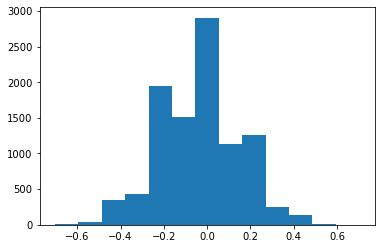

In [6]:
plt.figure()
plt.hist(score, bins=13)
plt.show()

In [8]:
from scipy.stats import norm

x=0.18681318681318687

mean=np.mean(score)
sdev=np.std(score)

zscore = (x - mean)/sdev
print('zscore =',zscore)
print('% =',1-norm.cdf(zscore))

zscore = 1.1642089888677782
% = 0.12216966416908903


---
## Identifying shots following two makes or two misses

In [9]:
# Create new column 'follows_streak' that identifies shots following streaks of two makes or two misses
shot_df['follows_streak'] = shot_df.outcome.ne(shot_df['outcome'].shift())
shot_df['follows_streak'] = shot_df['follows_streak'].shift()
shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,True)
shot_df['follows_streak'] = ~shot_df['follows_streak']

# Intermediate columns to identify streaks of makes or misses
shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

# Create new columns 'follows_two_makes'
shot_df['follows_two_makes'] = shot_df.follows_streak == shot_df.new2
shot_df['follows_two_makes'] = shot_df['follows_two_makes'].astype(int)

# Create new columns 'follows_two_misses'
shot_df['follows_two_misses'] = shot_df.follows_streak ^ shot_df.new2
shot_df['follows_two_misses'] = shot_df['follows_two_misses'].astype(int)

# Drop intermediate columns
shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])

display(shot_df)

if sum(shot_df['follows_two_makes'])>0:
    print(f"Following two makes: {sum(shot_df[shot_df['follows_two_makes']==1]['outcome'])} out of \
{sum(shot_df['follows_two_makes'])} ({round(sum(shot_df[shot_df['follows_two_makes']==1]['outcome'])/sum(shot_df['follows_two_makes']),4)*100}%)")
else:
    print('Following two makes: 0 out of 0 (0.0%)')

if sum(shot_df['follows_two_makes'])>0:
    print(f"Following two misses: {sum(shot_df[shot_df['follows_two_misses']==1]['outcome'])} out of \
{sum(shot_df['follows_two_misses'])} ({round(sum(shot_df[shot_df['follows_two_misses']==1]['outcome'])/sum(shot_df['follows_two_misses']),4)*100}%)")    
else:
    print('Following two misses: 0 out of 0 (0.0%)')
    
sum(shot_df[shot_df['follows_two_makes']==1]['outcome'])/sum(shot_df['follows_two_makes'])-\
sum(shot_df[shot_df['follows_two_misses']==1]['outcome'])/sum(shot_df['follows_two_misses'])

,quarter,outcome,time_remaining_secs,follows_make,follows_two_makes,follows_two_misses
0,1,0,655,0,0,0
1,1,0,606,0,0,0
2,1,1,329,0,0,1
3,1,1,305,1,0,0
4,1,0,148,1,1,0
5,1,1,104,0,0,0
6,1,0,40,1,0,0
7,1,1,0,0,0,0
8,2,1,304,1,0,0
9,2,1,241,1,1,0


Following two makes: 5 out of 7 (71.43%)
Following two misses: 3 out of 8 (37.5%)


0.3392857142857143

---
## Comparing this string to 10,000 random permutations of itself

In [10]:
outcome = shot_df['outcome'].to_list()

score = []

for i in range(10000):
    random.shuffle(outcome)

    shot_df = pd.DataFrame(data=outcome, columns=['outcome'])
    
    # Create new column 'follows_streak' that identifies shots following streaks of two makes or two misses
    shot_df['follows_streak'] = shot_df.outcome.ne(shot_df['outcome'].shift())
    shot_df['follows_streak'] = shot_df['follows_streak'].shift()
    shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,True)
    shot_df['follows_streak'] = ~shot_df['follows_streak']

    # Intermediate columns to identify streaks of makes or misses
    shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
    shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

    # Create new columns 'follows_two_makes'
    shot_df['follows_two_makes'] = shot_df.follows_streak == shot_df.new2
    shot_df['follows_two_makes'] = shot_df['follows_two_makes'].astype(int)

    # Create new columns 'follows_two_misses'
    shot_df['follows_two_misses'] = shot_df.follows_streak ^ shot_df.new2
    shot_df['follows_two_misses'] = shot_df['follows_two_misses'].astype(int)

    # Drop intermediate columns
    shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])

    score.append(sum(shot_df[shot_df['follows_two_makes']==1]['outcome'])/sum(shot_df['follows_two_makes'])-\
    sum(shot_df[shot_df['follows_two_misses']==1]['outcome'])/sum(shot_df['follows_two_misses']))

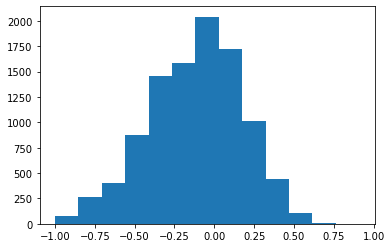

In [11]:
plt.figure()
plt.hist(score, bins=13)
plt.show()

In [12]:
from scipy.stats import norm

x=0.3392857142857143

mean=np.mean(score)
sdev=np.std(score)

zscore = (x - mean)/sdev
print('zscore =',zscore)
print('% =',1-norm.cdf(zscore))

zscore = 1.5581115191397308
% = 0.059603407260427343


---
## Identifying shots following three makes or three misses

In [13]:
# Create new column 'follows_streak' that identifies shots following streaks of three makes or three misses
shot_df['follows_streak'] = (shot_df.outcome == shot_df.outcome.shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift())
shot_df['follows_streak'] = shot_df['follows_streak'].shift()
shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,False)

# Intermediate columns to identify streaks of makes or misses
shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

# Create new columns 'follows_three_makes' and 'success_following_three_makes'
shot_df['follows_three_makes'] = shot_df.follows_streak == shot_df.new2
shot_df['follows_three_makes'] = shot_df['follows_three_makes'].astype(int)

# Create new columns 'follows_three_misses' and 'success_following_three_misses'
shot_df['follows_three_misses'] = shot_df.follows_streak ^ shot_df.new2
shot_df['follows_three_misses'] = shot_df['follows_three_misses'].astype(int)

# Drop intermediate columns
shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])

display(shot_df)

if sum(shot_df['follows_three_makes'])>0:
    print(f"Following three makes: {sum(shot_df[shot_df['follows_three_makes']==1]['outcome'])} out of \
{sum(shot_df['follows_three_makes'])} ({round(sum(shot_df[shot_df['follows_three_makes']==1]['outcome'])/sum(shot_df['follows_three_makes']),4)*100}%)")
else:
    print('Following three misses: 0 out of 0 (0.0%)')

if sum(shot_df['follows_three_misses'])>0:
    print(f"Following three misses: {sum(shot_df[shot_df['follows_three_misses']==1]['outcome'])} out of \
{sum(shot_df['follows_three_misses'])} ({round(sum(shot_df[shot_df['follows_three_misses']==1]['outcome'])/sum(shot_df['follows_three_misses']),4)*100}%)")   
else:
    print('Following three misses: 0 out of 0 (0.0%)')
    
sum(shot_df[shot_df['follows_three_makes']==1]['outcome'])/sum(shot_df['follows_three_makes'])-\
sum(shot_df[shot_df['follows_three_misses']==1]['outcome'])/sum(shot_df['follows_three_misses'])

,outcome,follows_two_makes,follows_two_misses,follows_three_makes,follows_three_misses
0,0,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,1,0,0,0,0
5,0,0,0,0,0
6,1,0,0,0,0
7,0,0,0,0,0
8,0,0,0,0,0
9,1,0,1,0,0


Following three makes: 0 out of 1 (0.0%)
Following three misses: 1 out of 1 (100.0%)


-1.0

---
## Identifying shots following four makes or four misses

In [14]:
# Create new column 'follows_streak' that identifies shots following streaks of four makes or four misses
shot_df['follows_streak'] = (shot_df.outcome == shot_df.outcome.shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift().shift())
shot_df['follows_streak'] = shot_df['follows_streak'].shift()
shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,False)

# Intermediate columns to identify streaks of makes or misses
shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

# Create new columns 'follows_two_makes' and 'success_following_two_makes'
shot_df['follows_four_makes'] = shot_df.follows_streak == shot_df.new2
shot_df['follows_four_makes'] = shot_df['follows_four_makes'].astype(int)

# Create new columns 'follows_four_misses' and 'success_following_four_misses'
shot_df['follows_four_misses'] = shot_df.follows_streak ^ shot_df.new2
shot_df['follows_four_misses'] = shot_df['follows_four_misses'].astype(int)

# Drop intermediate columns
shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])

display(shot_df)

if sum(shot_df['follows_four_makes'])>0:
    print(f"Following four makes: {sum(shot_df[shot_df['follows_four_makes']==1]['outcome'])} out of \
{sum(shot_df['follows_four_makes'])} ({round(sum(shot_df[shot_df['follows_four_makes']==1]['outcome'])/sum(shot_df['follows_four_makes']),4)*100}%)")
else:
    print('Following four makes: 0 out of 0 (0.0%)')

if sum(shot_df['follows_four_misses'])>0:
    print(f"Following four misses: {sum(shot_df[shot_df['follows_four_misses']==1]['outcome'])} out of \
{sum(shot_df['follows_four_misses'])} ({round(sum(shot_df[shot_df['follows_four_misses']==1]['outcome'])/sum(shot_df['follows_four_misses']),4)*100}%)")  
else:
    print('Following four misses: 0 out of 0 (0.0%)')
    
sum(shot_df[shot_df['follows_four_makes']==1]['outcome'])/sum(shot_df['follows_four_makes'])-\
sum(shot_df[shot_df['follows_four_misses']==1]['outcome'])/sum(shot_df['follows_four_misses'])

,outcome,follows_two_makes,follows_two_misses,follows_three_makes,follows_three_misses,follows_four_makes,follows_four_misses
0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0
5,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0
7,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0
9,1,0,1,0,0,0,0


Following four makes: 0 out of 0 (0.0%)
Following four misses: 0 out of 0 (0.0%)


ZeroDivisionError: division by zero

---
## Get a list of all games in a season to loop over

In [15]:
# Send a get request and assign the response to a variable for a single team and season
response = requests.get('https://www.basketball-reference.com/teams/GSW/2019_games.html')
    
# Turn the undecoded content into a Beautiful Soup object and assign it to a variable
soup = BeautifulSoup(response.content, 'html.parser')

# Retrieve all tags that contain desired text and convert to string
href_tags = soup.find_all(href=True)
href_tags = [str(item) for item in href_tags]

# Store in dataframe
href_tags = pd.DataFrame(data=href_tags)

# Filter for boxscores only
searchfor = ['boxscores/2018','boxscores/2019']
href_tags = href_tags[href_tags[0].str.contains('|'.join(searchfor))].reset_index().drop(columns=['index'])

# Split string to get desired output
href_tags = href_tags[0].str.split("/",expand=True)
href_tags = href_tags[2].str.split(".html",expand=True).drop(columns=1)

# Convert array to list to loop through
games = href_tags[0].tolist()

In [16]:
len(games)

104

--- 
## Retrieving every following opportunity in an entire season

In [17]:
shot_strings = []
scores = []

number_of_shots = []
total_number_of_shots = []

follows_a_make = []
success_following_a_make = []
follows_a_miss = []
success_following_a_miss = []

follows_2_makes = []
success_following_2_makes = []
follows_2_misses = []
success_following_2_misses = []

follows_3_makes = []
success_following_3_makes = []
follows_3_misses = []
success_following_3_misses = []

follows_4_makes = []
success_following_4_makes = []
follows_4_misses = []
success_following_4_misses = []

for game in games:
    
    # Send a get request and assign the response to a variable
    response = requests.get(f'https://www.basketball-reference.com/boxscores/shot-chart/{game}.html')
    
    # Turn the undecoded content into a Beautiful Soup object and assign it to a variable
    soup = BeautifulSoup(response.content, 'html.parser')  
    
    # Scrape makes and misses by quarter
    q1makes = soup.find_all(class_='tooltip q-1 p-curryst01 make')
    q1misses = soup.find_all(class_='tooltip q-1 p-curryst01 miss')
    q2makes = soup.find_all(class_='tooltip q-2 p-curryst01 make')
    q2misses = soup.find_all(class_='tooltip q-2 p-curryst01 miss')
    q3makes = soup.find_all(class_='tooltip q-3 p-curryst01 make')
    q3misses = soup.find_all(class_='tooltip q-3 p-curryst01 miss')
    q4makes = soup.find_all(class_='tooltip q-4 p-curryst01 make')
    q4misses = soup.find_all(class_='tooltip q-4 p-curryst01 miss')

    # Potential OT too
    q5makes = soup.find_all(class_='tooltip q-5 p-curryst01 make')
    q5misses = soup.find_all(class_='tooltip q-5 p-curryst01 miss')
    q6makes = soup.find_all(class_='tooltip q-6 p-curryst01 make')
    q6misses = soup.find_all(class_='tooltip q-6 p-curryst01 miss')

    # Add html from above to list and convert to string
    shot_list = list(q1makes+q2makes+q3makes+q4makes+q5makes+q6makes+q1misses+q2misses+q3misses+q4misses+q5misses+q6misses)
    shot_list = [str(item) for item in shot_list]
    
    # If list is empty, skip to next game...
    if not shot_list:
        pass
    
    # Otherwise, continue...
    else:
        
        # Store list in dataframe
        shot_df = pd.DataFrame(data=shot_list)

        # Expand string to form new columns
        shot_df = shot_df[0].str.split(" ",expand=True)

        # Select and name useful columns
        shot_df = shot_df.loc[:,(2,8,11)]
        shot_df.columns = ['quarter','time','outcome']
        
        # Format quarter as integer
        shot_df['quarter'] = shot_df['quarter'].str.slice(start=2).astype(int)

        # Separate time into component parts and total as 'time_remaining_secs'
        shot_df['minutes_remaining'] = shot_df['time'].str.split(":", expand=True).drop(columns=1).astype(int)
        shot_df['seconds_remaining'] = shot_df['time'].str.split(":", expand=True).drop(columns=0)
        shot_df['seconds_remaining'] = shot_df['seconds_remaining'].str.slice(stop=-2).astype(int)
        shot_df['time_remaining_secs'] = shot_df['minutes_remaining']*60+shot_df['seconds_remaining']
        shot_df = shot_df.drop(columns= ['time', 'minutes_remaining', 'seconds_remaining'])

        # Sort shots in ascending order
        shot_df = shot_df.sort_values(by=['quarter','time_remaining_secs'], ascending=[True, False]).reset_index().drop(columns=['index'])
        
        # Convert 'outcome' to binary
        shot_df['outcome'] = shot_df['outcome'].replace('made',1)
        shot_df['outcome'] = shot_df['outcome'].replace('missed',0).astype(int)

        # AFTER A SINGLE MAKE OR MISS
        
        # Create new column 'follows_make' that identifies shots following a made shot
        shot_df['follows_make'] = shot_df['outcome'].shift()
        shot_df['follows_make'] = shot_df['follows_make'].replace(np.nan,0).astype(int)
          
        # Append to list
        number_of_shots.append(len(shot_df['outcome']))
        follows_a_make.append(sum(shot_df['follows_make']))
        success_following_a_make.append(sum(shot_df[shot_df['follows_make']==1]['outcome']))
        follows_a_miss.append(len(shot_df['follows_make'])-sum(shot_df['follows_make'])-1)
        success_following_a_miss.append(sum(shot_df[shot_df['follows_make']==0]['outcome'][1:]))

        # AFTER TWO MAKES OR TWO MISSES
        
        # Create new column 'follows_streak' that identifies shots following streaks of two makes or two misses
        shot_df['follows_streak'] = shot_df.outcome.ne(shot_df['outcome'].shift())
        shot_df['follows_streak'] = shot_df['follows_streak'].shift()
        shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,True)
        shot_df['follows_streak'] = ~shot_df['follows_streak']

        # Intermediate columns to identify streaks of makes or misses
        shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
        shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

        # Create new columns 'follows_two_makes'
        shot_df['follows_two_makes'] = shot_df.follows_streak == shot_df.new2
        shot_df['follows_two_makes'] = shot_df['follows_two_makes'].astype(int)

        # Create new columns 'follows_two_misses'
        shot_df['follows_two_misses'] = shot_df.follows_streak ^ shot_df.new2
        shot_df['follows_two_misses'] = shot_df['follows_two_misses'].astype(int)

        # Drop intermediate columns
        shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])

        # Append to list
        follows_2_makes.append(sum(shot_df['follows_two_makes']))
        success_following_2_makes.append(sum(shot_df[shot_df['follows_two_makes']==1]['outcome']))
        follows_2_misses.append(sum(shot_df['follows_two_misses']))
        success_following_2_misses.append(sum(shot_df[shot_df['follows_two_misses']==1]['outcome']))
        
        # AFTER THREE MAKES OR THREE MISSES
        
        # Create new column 'follows_streak' that identifies shots following streaks of three makes or three misses
        shot_df['follows_streak'] = (shot_df.outcome == shot_df.outcome.shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift())
        shot_df['follows_streak'] = shot_df['follows_streak'].shift()
        shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,False)

        # Intermediate columns to identify streaks of makes or misses
        shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
        shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

        # Create new columns 'follows_three_makes' and 'success_following_three_makes'
        shot_df['follows_three_makes'] = shot_df.follows_streak == shot_df.new2
        shot_df['follows_three_makes'] = shot_df['follows_three_makes'].astype(int)

        # Create new columns 'follows_three_misses' and 'success_following_three_misses'
        shot_df['follows_three_misses'] = shot_df.follows_streak ^ shot_df.new2
        shot_df['follows_three_misses'] = shot_df['follows_three_misses'].astype(int)

        # Drop intermediate columns
        shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])
        
        # Append to list
        follows_3_makes.append(sum(shot_df['follows_three_makes']))
        success_following_3_makes.append(sum(shot_df[shot_df['follows_three_makes']==1]['outcome']))
        follows_3_misses.append(sum(shot_df['follows_three_misses']))
        success_following_3_misses.append(sum(shot_df[shot_df['follows_three_misses']==1]['outcome']))
        
        # AFTER FOUR MAKES OR FOUR MISSES

        # Create new column 'follows_streak' that identifies shots following streaks of four makes or four misses
        shot_df['follows_streak'] = (shot_df.outcome == shot_df.outcome.shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift().shift())
        shot_df['follows_streak'] = shot_df['follows_streak'].shift()
        shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,False)

        # Intermediate columns to identify streaks of makes or misses
        shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
        shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

        # Create new columns 'follows_two_makes' and 'success_following_two_makes'
        shot_df['follows_four_makes'] = shot_df.follows_streak == shot_df.new2
        shot_df['follows_four_makes'] = shot_df['follows_four_makes'].astype(int)

        # Create new columns 'follows_four_misses' and 'success_following_four_misses'
        shot_df['follows_four_misses'] = shot_df.follows_streak ^ shot_df.new2
        shot_df['follows_four_misses'] = shot_df['follows_four_misses'].astype(int)

        # Drop intermediate columns
        shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])
        
        # Append to list
        follows_4_makes.append(sum(shot_df['follows_four_makes']))
        success_following_4_makes.append(sum(shot_df[shot_df['follows_four_makes']==1]['outcome']))
        follows_4_misses.append(sum(shot_df['follows_four_misses']))
        success_following_4_misses.append(sum(shot_df[shot_df['follows_four_misses']==1]['outcome']))
        
        #score = sum(shot_df[shot_df['follows_make']==1]['outcome'])/sum(shot_df['follows_make'])-\
        #sum(shot_df[shot_df['follows_make']==0]['outcome'][1:])/(len(shot_df['follows_make'])-sum(shot_df['follows_make'])-1)
        
        ###
        if sum(shot_df['follows_two_makes']) > 0:
            
            f_makes = sum(shot_df[shot_df['follows_two_makes']==1]['outcome'])/sum(shot_df['follows_two_makes'])
        
        else:
            
            f_makes = 0
            
        if sum(shot_df['follows_two_misses']) > 0:

            f_misses = sum(shot_df[shot_df['follows_two_misses']==1]['outcome'])/sum(shot_df['follows_two_misses'])
            
        else:
            
            f_misses = 0
            
        score = f_makes - f_misses
        
        ###
        outcome = shot_df['outcome'].to_list()
        
        shot_strings.append(outcome)
        scores.append(score)

total_number_of_shots.append(sum(number_of_shots))

print(f'Following a make: {sum(success_following_a_make)} out of {sum(follows_a_make)} ({round(sum(success_following_a_make)/sum(follows_a_make),4)*100}%)')
print(f'Following a miss: {sum(success_following_a_miss)} out of {sum(follows_a_miss)} ({round(sum(success_following_a_miss)/sum(follows_a_miss),4)*100}%)')
print(f'Following two makes: {sum(success_following_2_makes)} out of {sum(follows_2_makes)} ({round(sum(success_following_2_makes)/sum(follows_2_makes),4)*100}%)')
print(f'Following two misses: {sum(success_following_2_misses)} out of {sum(follows_2_misses)} ({round(sum(success_following_2_misses)/sum(follows_2_misses),4)*100}%)')
print(f'Following three makes: {sum(success_following_3_makes)} out of {sum(follows_3_makes)} ({round(sum(success_following_3_makes)/sum(follows_3_makes),4)*100}%)')
print(f'Following three misses: {sum(success_following_3_misses)} out of {sum(follows_3_misses)} ({round(sum(success_following_3_misses)/sum(follows_3_misses),4)*100}%)')
print(f'Following four makes: {sum(success_following_4_makes)} out of {sum(follows_4_makes)} ({round(sum(success_following_4_makes)/sum(follows_4_makes),4)*100}%)')
print(f'Following four misses: {sum(success_following_4_misses)} out of {sum(follows_4_misses)} ({round(sum(success_following_4_misses)/sum(follows_4_misses),4)*100}%)')

Following a make: 366 out of 786 (46.56%)
Following a miss: 419 out of 873 (48.0%)
Following two makes: 154 out of 354 (43.5%)
Following two misses: 207 out of 425 (48.71%)
Following three makes: 69 out of 147 (46.94%)
Following three misses: 100 out of 200 (50.0%)
Following four makes: 33 out of 66 (50.0%)
Following four misses: 48 out of 90 (53.33%)


In [18]:
scores[86]

0.4642857142857143

In [19]:
shot_strings[86]

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0]

In [19]:
import random

score = []

outcome = shot_strings[86]

for i in range(10000):
    random.shuffle(outcome)

    shot_df = pd.DataFrame(data=outcome, columns=['outcome'])

    # Create new column 'follows_make' that identifies shots following a made shot
    shot_df['follows_make'] = shot_df['outcome'].shift()
    shot_df['follows_make'] = shot_df['follows_make'].replace(np.nan,0).astype(int)
    
    # Create new column 'follows_streak' that identifies shots following streaks of two makes or two misses
    shot_df['follows_streak'] = shot_df.outcome.ne(shot_df['outcome'].shift())
    shot_df['follows_streak'] = shot_df['follows_streak'].shift()
    shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,True)
    shot_df['follows_streak'] = ~shot_df['follows_streak']

    # Intermediate columns to identify streaks of makes or misses
    shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
    shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

    # Create new columns 'follows_two_makes'
    shot_df['follows_two_makes'] = shot_df.follows_streak == shot_df.new2
    shot_df['follows_two_makes'] = shot_df['follows_two_makes'].astype(int)

    # Create new columns 'follows_two_misses'
    shot_df['follows_two_misses'] = shot_df.follows_streak ^ shot_df.new2
    shot_df['follows_two_misses'] = shot_df['follows_two_misses'].astype(int)

    # Drop intermediate columns
    shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])

    #score.append(sum(shot_df[shot_df['follows_make']==1]['outcome'])/sum(shot_df['follows_make'])-\
    #sum(shot_df[shot_df['follows_make']==0]['outcome'][1:])/(len(shot_df['follows_make'])-sum(shot_df['follows_make'])-1))
    
        ###
    if sum(shot_df['follows_two_makes']) > 0:

        f_makes = sum(shot_df[shot_df['follows_two_makes']==1]['outcome'])/sum(shot_df['follows_two_makes'])

    else:

        f_makes = 0

    if sum(shot_df['follows_two_misses']) > 0:

        f_misses = sum(shot_df[shot_df['follows_two_misses']==1]['outcome'])/sum(shot_df['follows_two_misses'])

    else:

        f_misses = 0

    score.append(f_makes - f_misses)

    ###

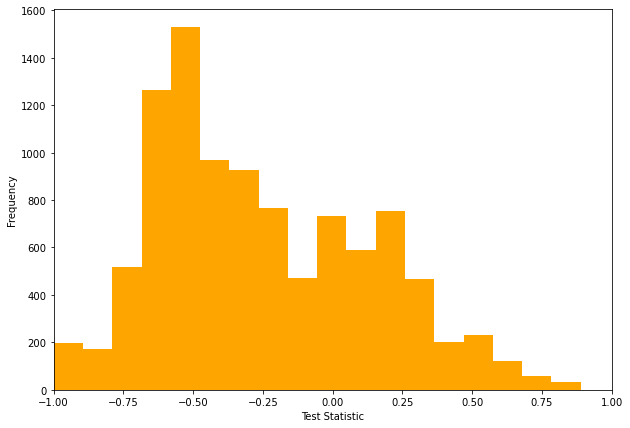

In [20]:
plt.figure(figsize=(10,7))
plt.hist(score, bins = 18, color='orange')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.xlim(-1,1)
plt.savefig('hist.png')

In [21]:
from scipy.stats import norm

x=scores[86]

mean=np.mean(score)
sdev=np.std(score)

zscore = (x - mean)/sdev
print('zscore =',zscore)
print('% =',1-norm.cdf(zscore))

zscore = 1.86691438089508
% = 0.03095677263885388


---
## Previous code as a function

In [22]:
def shots(code, abbr, year):
    
    '''

    '''
    shot_df_list = []
    
    ##### GETTING LIST OF GAMES #####
    
    # Send a get request and assign the response to a variable for a single team and season
    response = requests.get(f'https://www.basketball-reference.com/teams/{abbr}/{year}_games.html')
    
    # Turn the undecoded content into a Beautiful Soup object and assign it to a variable
    soup = BeautifulSoup(response.content, 'html.parser')

    # Retrieve all tags that contain desired text and convert to string
    href_tags = soup.find_all(href=True)
    href_tags = [str(item) for item in href_tags]

    # Store in dataframe
    href_tags = pd.DataFrame(data=href_tags)

    # Filter for boxscores only
    searchfor = [f'boxscores/{year-1}',f'boxscores/{year}']
    href_tags = href_tags[href_tags[0].str.contains('|'.join(searchfor))].reset_index().drop(columns=['index'])

    # Split string to get desired output
    href_tags = href_tags[0].str.split("/",expand=True)
    href_tags = href_tags[2].str.split(".html",expand=True).drop(columns=1)

    # Convert array to list to loop through
    games = href_tags[0].tolist()
    
    
    ##### GETTING SHOTS FROM EACH GAME #####
    
    number_of_shots = []
    total_number_of_shots = []

    follows_a_make = []
    success_following_a_make = []
    follows_a_miss = []
    success_following_a_miss = []

    follows_2_makes = []
    success_following_2_makes = []
    follows_2_misses = []
    success_following_2_misses = []

    follows_3_makes = []
    success_following_3_makes = []
    follows_3_misses = []
    success_following_3_misses = []

    follows_4_makes = []
    success_following_4_makes = []
    follows_4_misses = []
    success_following_4_misses = []

    for game in games:

        # Send a get request and assign the response to a variable
        response = requests.get(f'https://www.basketball-reference.com/boxscores/shot-chart/{game}.html')

        # Turn the undecoded content into a Beautiful Soup object and assign it to a variable
        soup = BeautifulSoup(response.content, 'html.parser')  

        # Scrape makes and misses by quarter
        q1makes = soup.find_all(class_=f'tooltip q-1 p-{code}01 make')
        q1misses = soup.find_all(class_=f'tooltip q-1 p-{code}01 miss')
        q2makes = soup.find_all(class_=f'tooltip q-2 p-{code}01 make')
        q2misses = soup.find_all(class_=f'tooltip q-2 p-{code}01 miss')
        q3makes = soup.find_all(class_=f'tooltip q-3 p-{code}01 make')
        q3misses = soup.find_all(class_=f'tooltip q-3 p-{code}01 miss')
        q4makes = soup.find_all(class_=f'tooltip q-4 p-{code}01 make')
        q4misses = soup.find_all(class_=f'tooltip q-4 p-{code}01 miss')

        # Potential OT too
        q5makes = soup.find_all(class_=f'tooltip q-5 p-{code}01 make')
        q5misses = soup.find_all(class_=f'tooltip q-5 p-{code}01 miss')
        q6makes = soup.find_all(class_=f'tooltip q-6 p-{code}01 make')
        q6misses = soup.find_all(class_=f'tooltip q-6 p-{code}01 miss')

        # Add html from above to list and convert to string
        shot_list = list(q1makes+q2makes+q3makes+q4makes+q5makes+q6makes+q1misses+q2misses+q3misses+q4misses+q5misses+q6misses)
        shot_list = [str(item) for item in shot_list]

        # If list is empty, skip to next game...
        if not shot_list:
            pass

        # Otherwise, continue...
        else:

            # Store list in dataframe
            shot_df = pd.DataFrame(data=shot_list)

            # Expand string to form new columns
            shot_df = shot_df[0].str.split(" ",expand=True)

            # Select and name useful columns
            shot_df = shot_df.loc[:,(2,8,11)]
            shot_df.columns = ['quarter','time','outcome']
            
            # Format quarter as integer
            shot_df['quarter'] = shot_df['quarter'].str.slice(start=2).astype(int)

            # Separate time into component parts and total as 'time_remaining_secs'
            shot_df['minutes_remaining'] = shot_df['time'].str.split(":", expand=True).drop(columns=1).astype(int)
            shot_df['seconds_remaining'] = shot_df['time'].str.split(":", expand=True).drop(columns=0)
            shot_df['seconds_remaining'] = shot_df['seconds_remaining'].str.slice(stop=-2).astype(int)
            shot_df['time_remaining_secs'] = shot_df['minutes_remaining']*60+shot_df['seconds_remaining']
            shot_df = shot_df.drop(columns= ['time', 'minutes_remaining', 'seconds_remaining'])

            # Sort shots in ascending order
            shot_df = shot_df.sort_values(by=['quarter','time_remaining_secs'], ascending=[True, False]).reset_index().drop(columns=['index'])
            
            # Convert 'outcome' to binary
            shot_df['outcome'] = shot_df['outcome'].replace('made',1)
            shot_df['outcome'] = shot_df['outcome'].replace('missed',0).astype(int)

            # AFTER A SINGLE MAKE OR MISS

            # Create new column 'follows_make' that identifies shots following a made shot
            shot_df['follows_make'] = shot_df['outcome'].shift()
            shot_df['follows_make'] = shot_df['follows_make'].replace(np.nan,0).astype(int)

            # Append to list
            number_of_shots.append(len(shot_df['outcome']))
            follows_a_make.append(sum(shot_df['follows_make']))
            success_following_a_make.append(sum(shot_df[shot_df['follows_make']==1]['outcome']))
            follows_a_miss.append(len(shot_df['follows_make'])-sum(shot_df['follows_make'])-1)
            success_following_a_miss.append(sum(shot_df[shot_df['follows_make']==0]['outcome'][1:]))

            # AFTER TWO MAKES OR TWO MISSES

            # Create new column 'follows_streak' that identifies shots following streaks of two makes or two misses
            shot_df['follows_streak'] = shot_df.outcome.ne(shot_df['outcome'].shift())
            shot_df['follows_streak'] = shot_df['follows_streak'].shift()
            shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,True)
            shot_df['follows_streak'] = ~shot_df['follows_streak']

            # Intermediate columns to identify streaks of makes or misses
            shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
            shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

            # Create new columns 'follows_two_makes'
            shot_df['follows_two_makes'] = shot_df.follows_streak == shot_df.new2
            shot_df['follows_two_makes'] = shot_df['follows_two_makes'].astype(int)

            # Create new columns 'follows_two_misses'
            shot_df['follows_two_misses'] = shot_df.follows_streak ^ shot_df.new2
            shot_df['follows_two_misses'] = shot_df['follows_two_misses'].astype(int)

            # Drop intermediate columns
            shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])

            # Append to list
            follows_2_makes.append(sum(shot_df['follows_two_makes']))
            success_following_2_makes.append(sum(shot_df[shot_df['follows_two_makes']==1]['outcome']))
            follows_2_misses.append(sum(shot_df['follows_two_misses']))
            success_following_2_misses.append(sum(shot_df[shot_df['follows_two_misses']==1]['outcome']))

            # AFTER THREE MAKES OR THREE MISSES

            # Create new column 'follows_streak' that identifies shots following streaks of three makes or three misses
            shot_df['follows_streak'] = (shot_df.outcome == shot_df.outcome.shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift())
            shot_df['follows_streak'] = shot_df['follows_streak'].shift()
            shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,False)

            # Intermediate columns to identify streaks of makes or misses
            shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
            shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

            # Create new columns 'follows_three_makes' and 'success_following_three_makes'
            shot_df['follows_three_makes'] = shot_df.follows_streak == shot_df.new2
            shot_df['follows_three_makes'] = shot_df['follows_three_makes'].astype(int)

            # Create new columns 'follows_three_misses' and 'success_following_three_misses'
            shot_df['follows_three_misses'] = shot_df.follows_streak ^ shot_df.new2
            shot_df['follows_three_misses'] = shot_df['follows_three_misses'].astype(int)

            # Drop intermediate columns
            shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])

            # Append to list
            follows_3_makes.append(sum(shot_df['follows_three_makes']))
            success_following_3_makes.append(sum(shot_df[shot_df['follows_three_makes']==1]['outcome']))
            follows_3_misses.append(sum(shot_df['follows_three_misses']))
            success_following_3_misses.append(sum(shot_df[shot_df['follows_three_misses']==1]['outcome']))

            # AFTER FOUR MAKES OR FOUR MISSES

            # Create new column 'follows_streak' that identifies shots following streaks of four makes or four misses
            shot_df['follows_streak'] = (shot_df.outcome == shot_df.outcome.shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift().shift())
            shot_df['follows_streak'] = shot_df['follows_streak'].shift()
            shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,False)

            # Intermediate columns to identify streaks of makes or misses
            shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
            shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

            # Create new columns 'follows_two_makes' and 'success_following_two_makes'
            shot_df['follows_four_makes'] = shot_df.follows_streak == shot_df.new2
            shot_df['follows_four_makes'] = shot_df['follows_four_makes'].astype(int)

            # Create new columns 'follows_four_misses' and 'success_following_four_misses'
            shot_df['follows_four_misses'] = shot_df.follows_streak ^ shot_df.new2
            shot_df['follows_four_misses'] = shot_df['follows_four_misses'].astype(int)

            # Drop intermediate columns
            shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])

            # Append to list
            follows_4_makes.append(sum(shot_df['follows_four_makes']))
            success_following_4_makes.append(sum(shot_df[shot_df['follows_four_makes']==1]['outcome']))
            follows_4_misses.append(sum(shot_df['follows_four_misses']))
            success_following_4_misses.append(sum(shot_df[shot_df['follows_four_misses']==1]['outcome']))

    total_number_of_shots.append(sum(number_of_shots))

    print(f'Following a make: {sum(success_following_a_make)} out of {sum(follows_a_make)} ({round(sum(success_following_a_make)/sum(follows_a_make),4)*100}%)')
    print(f'Following a miss: {sum(success_following_a_miss)} out of {sum(follows_a_miss)} ({round(sum(success_following_a_miss)/sum(follows_a_miss),4)*100}%)')
    print(f'Following two makes: {sum(success_following_2_makes)} out of {sum(follows_2_makes)} ({round(sum(success_following_2_makes)/sum(follows_2_makes),4)*100}%)')
    print(f'Following two misses: {sum(success_following_2_misses)} out of {sum(follows_2_misses)} ({round(sum(success_following_2_misses)/sum(follows_2_misses),4)*100}%)')
    print(f'Following three makes: {sum(success_following_3_makes)} out of {sum(follows_3_makes)} ({round(sum(success_following_3_makes)/sum(follows_3_makes),4)*100}%)')
    print(f'Following three misses: {sum(success_following_3_misses)} out of {sum(follows_3_misses)} ({round(sum(success_following_3_misses)/sum(follows_3_misses),4)*100}%)')
    print(f'Following four makes: {sum(success_following_4_makes)} out of {sum(follows_4_makes)} ({round(sum(success_following_4_makes)/sum(follows_4_makes),4)*100}%)')
    print(f'Following four misses: {sum(success_following_4_misses)} out of {sum(follows_4_misses)} ({round(sum(success_following_4_misses)/sum(follows_4_misses),4)*100}%)')
    
    return number_of_shots

In [ ]:
number_of_shots = shots('curryst','GSW', 2021)

In [ ]:
number_of_shots = shots('curryst','GSW', 2021)

In [ ]:
number_of_shots = shots('curryst','GSW', 2019)

In [ ]:
number_of_shots = shots('curryst','GSW', 2018)

In [ ]:
number_of_shots = shots('curryst','GSW', 2017)

In [ ]:
number_of_shots = shots('curryst','GSW', 2016)

In [85]:
number_of_shots = shots('curryst','GSW', 2015)

Following a make: 368 out of 809 (45.49%)
Following a miss: 433 out of 859 (50.41%)
Following two makes: 153 out of 352 (43.47%)
Following two misses: 198 out of 390 (50.77%)
Following three makes: 55 out of 145 (37.93%)
Following three misses: 84 out of 171 (49.120000000000005%)
Following four makes: 18 out of 51 (35.29%)
Following four misses: 38 out of 76 (50.0%)


In [23]:
number_of_shots = shots('curryst','GSW', 2015)

Following a make: 368 out of 809 (45.49%)
Following a miss: 433 out of 859 (50.41%)
Following two makes: 153 out of 352 (43.47%)
Following two misses: 198 out of 390 (50.77%)
Following three makes: 55 out of 145 (37.93%)
Following three misses: 84 out of 171 (49.120000000000005%)
Following four makes: 18 out of 51 (35.29%)
Following four misses: 38 out of 76 (50.0%)


In [ ]:
number_of_shots = shots('curryst','GSW', 2013)

In [87]:
len(number_of_shots)

101

---

## Simulating the previously ran season

In [88]:
total_shots = []

pct_following_a_make = []
pct_following_a_miss = []

pct_following_two_makes = []
pct_following_two_misses = []

pct_following_three_makes = []
pct_following_three_misses = []

pct_following_four_makes = []
pct_following_four_misses = []

for x in range(10000):
    
    shots_taken = []
    
    follows_a_make = []
    success_following_a_make = []
    follows_a_miss = []
    success_following_a_miss = []
    
    follows_2_makes = []
    success_following_2_makes = []
    follows_2_misses = []
    success_following_2_misses = []
    
    follows_3_makes = []
    success_following_3_makes = []
    follows_3_misses = []
    success_following_3_misses = []
    
    follows_4_makes = []
    success_following_4_makes = []
    follows_4_misses = []
    success_following_4_misses = []

    for i,j in enumerate(number_of_shots):
        
        # Create a random string
        shot_df = np.random.binomial(1, 0.459, j)
        shot_df = pd.DataFrame(data=shot_df)
        shot_df.columns = ['outcome']
        
        # AFTER A SINGLE MAKE OR MISS
        
        # Create new column 'follows_make' that identifies shots following a made shot
        shot_df['follows_make'] = shot_df['outcome'].shift()
        shot_df['follows_make'] = shot_df['follows_make'].replace(np.nan,0).astype(int)
          
        # Append to list
        shots_taken.append(len(shot_df['outcome']))
        follows_a_make.append(sum(shot_df['follows_make']))
        success_following_a_make.append(sum(shot_df[shot_df['follows_make']==1]['outcome']))
        follows_a_miss.append(len(shot_df['follows_make'])-sum(shot_df['follows_make'])-1)
        success_following_a_miss.append(sum(shot_df[shot_df['follows_make']==0]['outcome'][1:]))
        
        # AFTER TWO MAKES OR TWO MISSES
        
        # Create new column 'follows_streak' that identifies shots following streaks of two makes or two misses
        shot_df['follows_streak'] = shot_df.outcome.ne(shot_df['outcome'].shift())
        shot_df['follows_streak'] = shot_df['follows_streak'].shift()
        shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,True)
        shot_df['follows_streak'] = ~shot_df['follows_streak']

        # Intermediate columns to identify streaks of makes or misses
        shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
        shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

        # Create new columns 'follows_two_makes'
        shot_df['follows_two_makes'] = shot_df.follows_streak == shot_df.new2
        shot_df['follows_two_makes'] = shot_df['follows_two_makes'].astype(int)

        # Create new columns 'follows_two_misses'
        shot_df['follows_two_misses'] = shot_df.follows_streak ^ shot_df.new2
        shot_df['follows_two_misses'] = shot_df['follows_two_misses'].astype(int)

        # Drop intermediate columns
        shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])

        # Append to list
        follows_2_makes.append(sum(shot_df['follows_two_makes']))
        success_following_2_makes.append(sum(shot_df[shot_df['follows_two_makes']==1]['outcome']))
        follows_2_misses.append(sum(shot_df['follows_two_misses']))
        success_following_2_misses.append(sum(shot_df[shot_df['follows_two_misses']==1]['outcome']))
            
        # AFTER THREE MAKES OR THREE MISSES
        
        # Create new column 'follows_streak' that identifies shots following streaks of three makes or three misses
        shot_df['follows_streak'] = (shot_df.outcome == shot_df.outcome.shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift())
        shot_df['follows_streak'] = shot_df['follows_streak'].shift()
        shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,False)

        # Intermediate columns to identify streaks of makes or misses
        shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
        shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

        # Create new columns 'follows_three_makes' and 'success_following_three_makes'
        shot_df['follows_three_makes'] = shot_df.follows_streak == shot_df.new2
        shot_df['follows_three_makes'] = shot_df['follows_three_makes'].astype(int)

        # Create new columns 'follows_three_misses' and 'success_following_three_misses'
        shot_df['follows_three_misses'] = shot_df.follows_streak ^ shot_df.new2
        shot_df['follows_three_misses'] = shot_df['follows_three_misses'].astype(int)

        # Drop intermediate columns
        shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])
        
        # Append to list
        follows_3_makes.append(sum(shot_df['follows_three_makes']))
        success_following_3_makes.append(sum(shot_df[shot_df['follows_three_makes']==1]['outcome']))
        follows_3_misses.append(sum(shot_df['follows_three_misses']))
        success_following_3_misses.append(sum(shot_df[shot_df['follows_three_misses']==1]['outcome']))
        
        # AFTER FOUR MAKES OR FOUR MISSES

        # Create new column 'follows_streak' that identifies shots following streaks of four makes or four misses
        shot_df['follows_streak'] = (shot_df.outcome == shot_df.outcome.shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift().shift())
        shot_df['follows_streak'] = shot_df['follows_streak'].shift()
        shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,False)

        # Intermediate columns to identify streaks of makes or misses
        shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
        shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

        # Create new columns 'follows_two_makes' and 'success_following_two_makes'
        shot_df['follows_four_makes'] = shot_df.follows_streak == shot_df.new2
        shot_df['follows_four_makes'] = shot_df['follows_four_makes'].astype(int)

        # Create new columns 'follows_four_misses' and 'success_following_four_misses'
        shot_df['follows_four_misses'] = shot_df.follows_streak ^ shot_df.new2
        shot_df['follows_four_misses'] = shot_df['follows_four_misses'].astype(int)

        # Drop intermediate columns
        shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])
        
        # Append to list
        follows_4_makes.append(sum(shot_df['follows_four_makes']))
        success_following_4_makes.append(sum(shot_df[shot_df['follows_four_makes']==1]['outcome']))
        follows_4_misses.append(sum(shot_df['follows_four_misses']))
        success_following_4_misses.append(sum(shot_df[shot_df['follows_four_misses']==1]['outcome']))

    total_shots.append(sum(shots_taken))
    
    pct_following_a_make.append(sum(success_following_a_make)/sum(follows_a_make))
    pct_following_a_miss.append(sum(success_following_a_miss)/sum(follows_a_miss))
    
    pct_following_two_makes.append(sum(success_following_2_makes)/sum(follows_2_makes))
    pct_following_two_misses.append(sum(success_following_2_misses)/sum(follows_2_misses))
    
    pct_following_three_makes.append(sum(success_following_3_makes)/sum(follows_3_makes))
    pct_following_three_misses.append(sum(success_following_3_misses)/sum(follows_3_misses))
   
    pct_following_four_makes.append(sum(success_following_4_makes)/sum(follows_4_makes))
    pct_following_four_misses.append(sum(success_following_4_misses)/sum(follows_4_misses))

print(f'Average pct of makes following a make: ({round(np.mean(pct_following_a_make), 4) * 100}%)')
print(f'Average pct of makes following a miss: ({round(np.mean(pct_following_a_miss), 4) * 100}%)')
print(f'Average pct of makes following two makes: ({round(np.mean(pct_following_two_makes), 4) * 100}%)')
print(f'Average pct of makes following two misses: ({round(np.mean(pct_following_two_misses), 4) * 100}%)')
print(f'Average pct of makes following three makes: ({round(np.mean(pct_following_three_makes), 4) * 100}%)')
print(f'Average pct of makes following three misses: ({round(np.mean(pct_following_three_misses), 4) * 100}%)')
print(f'Average pct of makes following four makes: ({round(np.mean(pct_following_four_makes), 4) * 100}%)')
print(f'Average pct of makes following four misses: ({round(np.mean(pct_following_four_misses), 4) * 100}%)')

Average pct of makes following a make: (45.86%)
Average pct of makes following a miss: (45.95%)
Average pct of makes following two makes: (45.78%)
Average pct of makes following two misses: (46.02%)
Average pct of makes following three makes: (45.59%)
Average pct of makes following three misses: (46.14%)
Average pct of makes following four makes: (45.24%)
Average pct of makes following four misses: (46.35%)


In [89]:
len(shots_taken)

101

---

Following a make: 368 out of 809 (45.49%)

Following a miss: 433 out of 859 (50.41%)

Following two makes: 153 out of 352 (43.47%)

Following two misses: 198 out of 390 (50.77%)

Following three makes: 55 out of 145 (37.93%)

Following three misses: 84 out of 171 (49.120000000000005%)

Following four makes: 18 out of 51 (35.29%)

Following four misses: 38 out of 76 (50.0%)

zscore = -0.20375487290763808
% = 0.5807274704122105


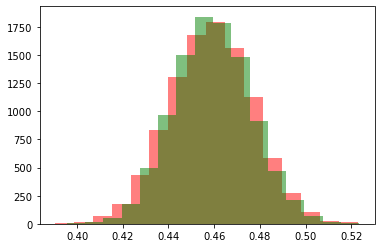

In [91]:
from scipy.stats import norm

x=0.4549

mean=np.mean(pct_following_a_make)
sdev=np.std(pct_following_a_make)

zscore = (x - mean)/sdev
print('zscore =',zscore)
print('% =',1-norm.cdf(zscore))

plt.figure()
plt.hist(pct_following_a_make, bins=16, color='r', alpha=0.5)
plt.hist(pct_following_a_miss, bins=16, color='g', alpha=0.5)
plt.show()

---

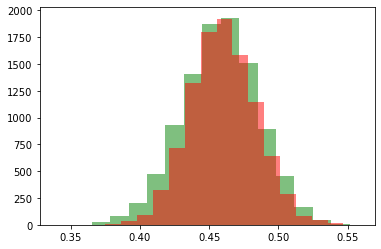

zscore = -0.8423789057965249
% = 0.8002120517334484


In [92]:
x=0.4347

plt.figure()
plt.hist(pct_following_two_makes, bins=16, color='g', alpha=0.5)
plt.hist(pct_following_two_misses, bins=16, color='r', alpha=0.5)
plt.show()

mean=np.mean(pct_following_two_makes)
sdev=np.std(pct_following_two_makes)

zscore = (x - mean)/sdev
print('zscore =',zscore)
print('% =', 1-norm.cdf(zscore))


---

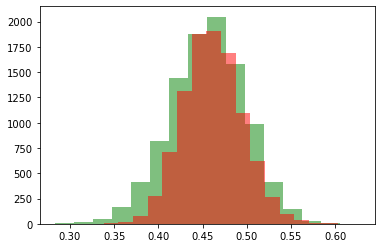

zscore = -1.8086619642488397
% = 0.03525176775740221


In [94]:
x=0.3793

plt.figure()
plt.hist(pct_following_three_makes, bins=16, color='g', alpha=0.5)
plt.hist(pct_following_three_misses, bins=16, color='r', alpha=0.5)
plt.show()

mean=np.mean(pct_following_three_makes)
sdev=np.std(pct_following_three_makes)

zscore = (x - mean)/sdev
print('zscore =',zscore)
print('% =',norm.cdf(zscore))

---

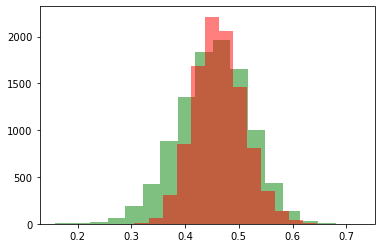

zscore = -2.361347654427052
% = 0.009104325832420847


In [96]:
x=0.3529

plt.figure()
plt.hist(pct_following_four_makes, bins=16, color='g', alpha=0.5)
plt.hist(pct_following_four_misses, bins=16, color='r', alpha=0.5)
plt.show()

mean=np.mean(pct_following_four_misses)
sdev=np.std(pct_following_four_misses)

zscore = (x - mean)/sdev
print('zscore =',zscore)
print('% =', norm.cdf(zscore))